# Invoke Bedrock model for code generation

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

## Introduction

In this notebook we show you how to use a LLM to generate code based on the text prompt. We will use Bedrock's Claude using the Boto3 API. 

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

**Note:** *This notebook can be run within or outside of AWS environment.*

#### Context
To demonstrate the code generation capability of Amazon Bedrock, we will explore the use of Boto3 client to communicate with Amazon Bedrock API. We will demonstrate different configurations available as well as how simple input can lead to desired outputs. We will explore code generation for two use cases:
1. Python code generation for analytical QnA
2. SQL query generation

#### Pattern
In both use cases, we will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model under the hood to generate an output without providing any additional example. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

![](../imgs/bedrock-code-gen.png)

## Use case 1 - Python code generation for Analytical QnA
To demonstrate the generation capability of models in Amazon Bedrock, let's take the use case of code generation with Python to do some basic analytical QnA.

#### Persona

You are Moe, a Data Analyst, at AnyCompany. The company wants to understand its sales performance for different products for different products over the past year. You have been provided a dataset named sales.csv. The dataset contains the following columns:

- Date (YYYY-MM-DD) format
- Product_ID (unique identifer for each product)
- Price (price at which each product was sold)

#### Implementation
To fulfill this use case, in this notebook we will show how to generate code for a given prompt. We will use the Anthropic Claude v2 using the Amazon Bedrock API with Boto3 client. 

## Setup


In [2]:
import json
import os
import sys

import boto3
import botocore

boto3_bedrock = boto3.client('bedrock-runtime')

## Code Generation

Following on the use case explained above, let's prepare an input for  the Amazon Bedrock service to generate python program for our use-case.

#### Lab setup - create sample sales.csv data for this lab.



In [15]:
# create sales.csv file
import csv

data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

# Write data to sales.csv
with open('sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


#### Analyzing sales with Amazon Bedrock generated Python program

In [33]:
model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
max_tokens = 4096
top_p = 0.5
top_k = 250
temperature = 0.5

# Create the prompt
# Analyzing sales

prompt = """
You have a CSV, sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, not span multiple lines unnessarily, and prefer to use standard libraries. Ensure that you use a list when selecting mulitple columns with pandas, for example [['price', 'units_sold']], and convert to DatetimeIndex where needed. Return only python code without any surrounding text, explanation or context.
"""

# Prompt with user turn only.
messages = [{"role": "user", "content":  prompt}]

#### Invoke the Anthropic Claude model

In [34]:
body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages, 
            "temperature": temperature,
            "top_p": top_p, 
            "top_k": top_k
        }
    )

response = boto3_bedrock.invoke_model(body=body, modelId=model_id)
response_body = json.loads(response.get('body').read())
print(response_body['content'][0]['text'])

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
sales_data = pd.read_csv('sales.csv', parse_dates=['date'])

# Convert the 'date' column to DatetimeIndex
sales_data = sales_data.set_index('date')

# Calculate total revenue
sales_data['revenue'] = sales_data['price'] * sales_data['units_sold']
total_revenue = sales_data['revenue'].sum()

# Find the product with the highest revenue
product_revenue = sales_data.groupby('product_id')['revenue'].sum().sort_values(ascending=False)
highest_revenue_product = product_revenue.index[0]

# Find the date with the highest revenue
date_revenue = sales_data.groupby(sales_data.index)['revenue'].sum().sort_values(ascending=False)
highest_revenue_date = date_revenue.index[0]

# Visualize monthly sales
monthly_sales = sales_data.resample('M')['revenue'].sum()
monthly_sales.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

print(f"Total revenue for the year: {total_re

#### (Optional) Execute the Bedrock generated code for validation. Go to text editor to copy the generated code as printed output can be trucncated. Replace the code in below cell.

/tmp/ipykernel_3769/3830433100.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = sales_data.resample('M')['revenue'].sum()


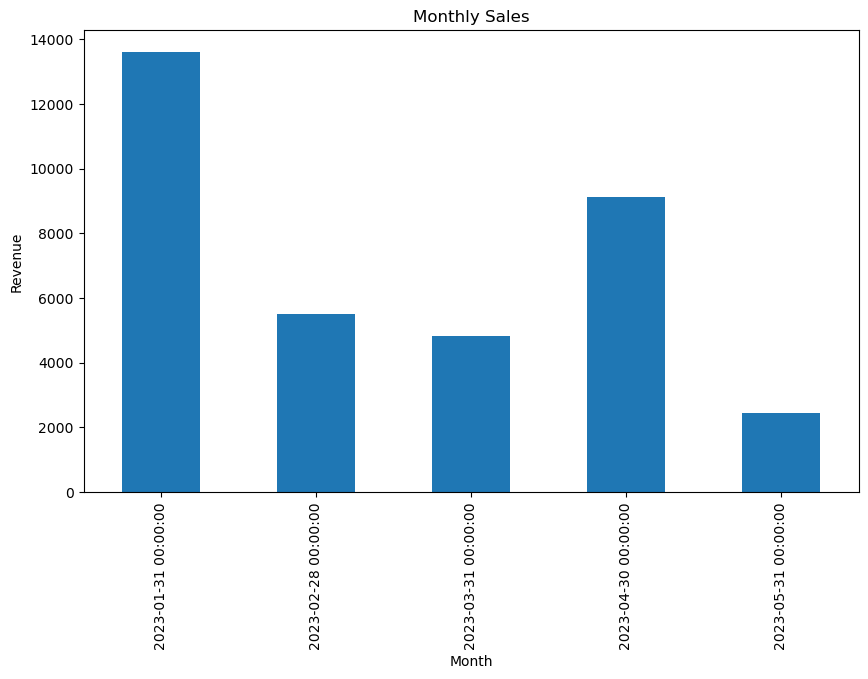

Total revenue for the year: 35490
Product with the highest revenue: P003
Date with the highest revenue: 2023-04-23 00:00:00


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
sales_data = pd.read_csv('sales.csv', parse_dates=['date'])

# Convert the 'date' column to DatetimeIndex
sales_data = sales_data.set_index('date')

# Calculate total revenue
sales_data['revenue'] = sales_data['price'] * sales_data['units_sold']
total_revenue = sales_data['revenue'].sum()

# Find the product with the highest revenue
product_revenue = sales_data.groupby('product_id')['revenue'].sum().sort_values(ascending=False)
highest_revenue_product = product_revenue.index[0]

# Find the date with the highest revenue
date_revenue = sales_data.groupby(sales_data.index)['revenue'].sum().sort_values(ascending=False)
highest_revenue_date = date_revenue.index[0]

# Visualize monthly sales
monthly_sales = sales_data.resample('M')['revenue'].sum()
monthly_sales.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

print(f"Total revenue for the year: {total_revenue}")
print(f"Product with the highest revenue: {highest_revenue_product}")
print(f"Date with the highest revenue: {highest_revenue_date}")

___

## Use case 2 - SQL query generation

To demonstrate the generation capability of models in Amazon Bedrock, let's take the use case of code generation with Python to do some basic analytical QnA.

In this section we show you how to use a LLM to generate SQL Query to analyze Sales data.

We will use Bedrock's Claude model using the Boto3 API. 

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

**Note:** *This notebook can be run within or outside of AWS environment.*

#### Context
To demonstrate the SQL code generation capability of Amazon Bedrock, we will explore the use of Boto3 client to communicate with Amazon Bedrock API. We will demonstrate different configurations available as well as how simple input can lead to desired outputs.

#### Pattern
We will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model under the hood to generate an output without providing any additional example. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

#### Use case
Let's take the use case to generate SQL queries to analyze sales data, focusing on trends, top products and average sales.

#### Persona
Maya is a business analyst, at AnyCompany primarily focusing on sales and inventory data. She is transitioning from Speadsheet analysis to data-driven analysis and want to use SQL to fetch specific data points effectively. She wants to use LLMs to generate SQL queries for her analysis. 

#### Implementation
To fulfill this use case, in this notebook we will show how to generate SQL queries. We will use the Anthropic Claude v2 model using the Amazon Bedrock API with Boto3 client. 

### Generate SQL Query

Following on the use case explained above, let's prepare an input for  the Amazon Bedrock service to generate SQL query.

In [36]:
model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
max_tokens = 512
top_p = 0.9
temperature = 0.5

# Create the prompt
# Analyzing sales

prompt = """
AnyCompany has a database with a table named sales_data containing sales records. The table has following columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Can you generate SQL queries for the below: 
- Identify the top 5 best selling products by total sales for the year 2023
- Calculate the monthly average sales for the year 2023
"""

# Prompt with user turn only.
messages = [{"role": "user", "content":  prompt}]

In [37]:
body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages, 
            "temperature": temperature,
            "top_p": top_p
        }
    )

response = boto3_bedrock.invoke_model(body=body, modelId=model_id)
response_body = json.loads(response.get('body').read())
print(response_body['content'][0]['text'])

Sure, here are the SQL queries for the given requirements:

1. Identify the top 5 best selling products by total sales for the year 2023:

```sql
SELECT
    product_id,
    SUM(units_sold) AS total_units_sold
FROM
    sales_data
WHERE
    date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY
    product_id
ORDER BY
    total_units_sold DESC
LIMIT 5;
```

This query first filters the data to include only records from the year 2023 using the `WHERE` clause. It then groups the records by `product_id` and calculates the sum of `units_sold` for each product using the `SUM` aggregate function. The results are ordered in descending order by the `total_units_sold` column, and the `LIMIT 5` clause restricts the output to the top 5 rows.

2. Calculate the monthly average sales for the year 2023:

```sql
SELECT
    EXTRACT(YEAR FROM date) AS year,
    EXTRACT(MONTH FROM date) AS month,
    ROUND(AVG(units_sold), 2) AS avg_monthly_sales
FROM
    sales_data
WHERE
    date BETWEEN '2023-01-01' AND '20

## Conclusion
You have now experimented with using `boto3` SDK which provides a vanilla exposure to Amazon Bedrock API. Using this API you generate a python program to analyze and visualize given sales data, and generate SQL statements based on an input task and schema.

### Take aways
- Adapt this notebook to experiment with different models available through Amazon Bedrock such as Amazon Titan and AI21 Labs Jurassic models!
